In [1]:
from swap_TN_direct import *

import json

import tracemalloc
import gc

/home/asingal/home/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/asingal/home/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


Timing analysis

In [37]:
# params
mean_photon_num = 0.1
num_modes = 8
efficiency = 0.9
truncations = [1,2,3,4,5,6]
# truncations = [1,2,3]
error_tolerances = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
TN_data = []
sparse_data = []

num_iter = 1

# tracemalloc.start()
for error_tolerance in error_tolerances:
    TN_data_error_tol = []
    for trunc in truncations:
        N = trunc+1
        
        time_taken = 0

        psi = new_ls(N, mean_photon_num, error_tolerance) 
        # TN data:
        # start = time.time()
        net_size_diff = 0
        for _ in range(num_iter):
            gc.collect()
            tracemalloc.start()
            # start_snapshot = tracemalloc.take_snapshot()


            psi = extend_MPS(psi)
            psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)
            
            idler_angles = np.array([0])
            signal_angles = np.linspace(0, np.pi, 15)

            coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False)
            
            # end_snapshot = tracemalloc.take_snapshot()
            # time_taken += time.time() - start
            current, peak =  tracemalloc.get_traced_memory()
            # memory_diff = end_snapshot.compare_to(start_snapshot, key_type = "filename")

            # for i in memory_diff:
            #     net_size_diff += i.size_diff
            net_size_diff += peak    

            tracemalloc.stop()
            tracemalloc.clear_traces()    
        
        TN_data_error_tol.append(net_size_diff/num_iter)
                
        print("truncation:", trunc)
    print("error:", error_tolerance)
    TN_data.append(TN_data_error_tol)
tracemalloc.stop()

truncation: 1
truncation: 2
truncation: 3
error: 0.0001
truncation: 1
truncation: 2
truncation: 3
error: 1e-05
truncation: 1
truncation: 2
truncation: 3
error: 1e-06
truncation: 1
truncation: 2
truncation: 3
error: 1e-07
truncation: 1
truncation: 2
truncation: 3
error: 1e-08
truncation: 1
truncation: 2
truncation: 3
error: 1e-09
truncation: 1
truncation: 2
truncation: 3
error: 1e-10


{0.0001: [562085.0, 566361.0, 870394.0], 1e-05: [562575.0, 646921.0, 1786765.0], 1e-06: [562303.0, 778955.0, 2779538.0], 1e-07: [562143.0, 1336930.0, 3931198.0], 1e-08: [565503.0, 1369823.0, 6722133.0], 1e-09: [560998.0, 1670940.0, 11958332.0], 1e-10: [566223.0, 1687125.0, 12220361.0]}
[562085.0, 566361.0, 870394.0] 0.0001
[562575.0, 646921.0, 1786765.0] 1e-05
[562303.0, 778955.0, 2779538.0] 1e-06
[562143.0, 1336930.0, 3931198.0] 1e-07
[565503.0, 1369823.0, 6722133.0] 1e-08
[560998.0, 1670940.0, 11958332.0] 1e-09
[566223.0, 1687125.0, 12220361.0] 1e-10


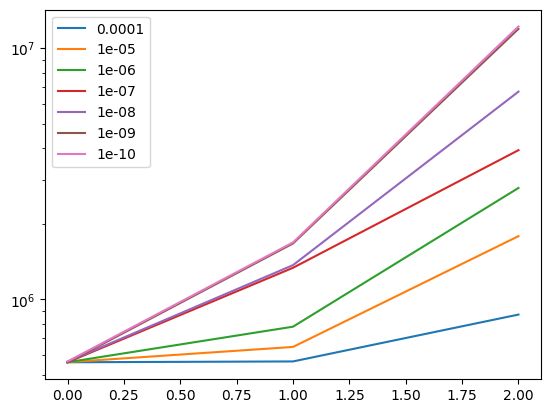

In [38]:
error_tolerances = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
timing_data = {error_tol:TN for error_tol, TN in zip(error_tolerances, TN_data)}
print(timing_data)

json.dump(timing_data, open(f"memory_data_mpn{int(mean_photon_num*100)}.json", "w"))

plt.figure()
for key,value in timing_data.items():
    plt.plot(value, label=f"{key}")
    print(value, key)
plt.legend()
plt.yscale('log')


[914428.0, 721580.0, 911211.0, 1782406.0, 4937995.0, 10166288.0] 0.0001
[592873.0, 834233.0, 1806583.0, 4758243.0, 11034310.0, 22902888.0] 1e-05
[567141.0, 785154.0, 2795511.0, 6357656.0, 14736415.0, 30724125.0] 1e-06
[564030.0, 1345012.0, 3949935.0, 10716348.0, 25023754.0, 51971301.0] 1e-07
[563158.0, 1374396.0, 6730150.0, 16173330.0, 32887361.0, 79429365.0] 1e-08
[563499.0, 1676705.0, 11966149.0, 20558461.0, 48003698.0, 99522574.0] 1e-09
[563130.0, 1690327.0, 12221687.0, 43453364.0, 62028149.0, 128644093.0] 1e-10
[562497.0, 1670576.0, 14933342.0, 59369082.0, 171239512.0, 236620861.0] 0.0001
[562652.0, 1686587.0, 16418714.0, 95729633.0, 341635964.0, 858208988.0] 1e-05
[563003.0, 1686410.0, 18474634.0, 119638769.0, 477689681.0, 1448287001.0] 1e-06
[562425.0, 1686532.0, 18467774.0, 129671137.0, 564639434.0, 1896128961.0] 1e-07
[562337.0, 1686301.0, 18467595.0, 129969564.0, 616116775.0, 2235076943.0] 1e-08
[563073.0, 1686118.0, 18467656.0, 129966638.0, 649197893.0, 2443017860.0] 1e-09
[5

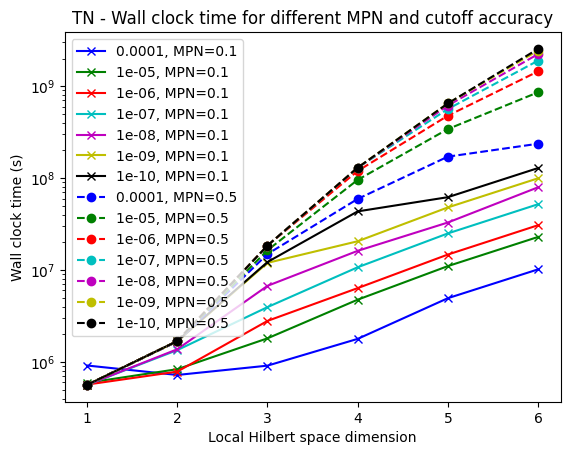

In [ ]:
# The below plots' data was collected using screen in python notebooks. The code was was otherwise the same as above. 

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
truncations = [1,2,3,4,5,6]

data_file = open("memory_data_mpn10.json", 'r')
data = json.load(data_file)

plt.figure()
plt.title("TN - Wall clock time for different MPN and cutoff accuracy")
# plt.ylim(10**-1,10**2.5)
plt.xlabel("Local Hilbert space dimension")
plt.ylabel("Wall clock time (s)")
for (key,value), color in zip(list(data.items()), colors):
    plt.plot(truncations, value, label=f"{key}, MPN=0.1", color = color, marker='x')
    print(value, key)
plt.legend()
plt.yscale('log')

data_file = open("memory_data_mpn50.json", 'r')
data = json.load(data_file)

for (key,value), color in zip(list(data.items()), colors):
    plt.plot(truncations, value, label=f"{key}, MPN=0.5", color = color, linestyle='dashed', marker='o')
    print(value, key)
plt.legend()
plt.yscale('log')

Statevector version

In [33]:
from swap_sparse_direct import *

mean_photon_num = 0.5
num_modes = 8
efficiency = 0.9
truncations = [1,2,3,4,5,6]
# truncations = [1,2,3]

sparse_data = []

# gc.collect()

sparse_data_error_tol = []
for trunc in truncations:

    a = qt.destroy(trunc+1).full()
    a = sp.csr_matrix(a)
    a_dag = a.T
    
    time_taken = 0

    N = trunc+1
    vacuum = create_vacuum_state(num_modes=num_modes, N=N)
    
    psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, 1e-10)

    # start = time.time()
    gc.collect()
    tracemalloc.start()
    # start_snapshot = tracemalloc.take_snapshot()

    # Sparse matrix data:
    TMSV_state_dense = extend_state_sparse(TMSV_state)
    post_BSM_State = bell_state_measurement_sparse(TMSV_state_dense, N, efficiency, a_dag)
    coincidence, idler_angles = rotate_and_measure_sparse(post_BSM_State, N, efficiency, a_dag)

    # time_taken += time.time() - start
    # end_snapshot = tracemalloc.take_snapshot()
    # memory_diff = end_snapshot.compare_to(start_snapshot, key_type = "filename")
    # print("start_snapshort:")
    # print(memory_diff)
    current, peak =  tracemalloc.get_traced_memory()


    # net_size_diff = 0
    # for i in memory_diff:
    #     net_size_diff += i.size_diff        
    sparse_data.append(peak)
    tracemalloc.stop()
    tracemalloc.clear_traces()

    # sparse_data.append(sparse_data_error_tol)
    # print(trunc)


(256, 256) 128 128
(6561, 6561) 4374 4374
(65536, 65536) 49152 49152
(390625, 390625) 312500 312500
(1679616, 1679616) 1399680 1399680
(5764801, 5764801) 4941258 4941258


[225650, 2661873, 31225757, 237483154, 1266333229, 5277557648]
[225650, 2661873, 31225757, 237483154, 1266333229, 5277557648]


/tmp/ipykernel_3301429/3524871800.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


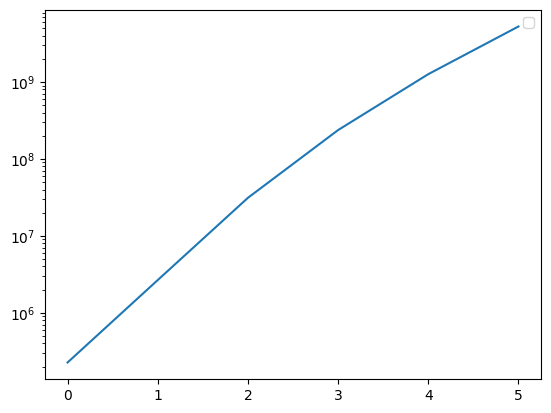

In [34]:
memory_data = sparse_data
print(memory_data)

json.dump(memory_data, open(f"sparse_memory_data_mpn{int(mean_photon_num*100)}.json", "w"))

plt.figure()
# for value in timing_data:
plt.plot(memory_data)
print(memory_data)
plt.legend()
plt.yscale('log')


[592873.0, 834233.0, 1806583.0, 4758243.0, 11034310.0, 22902888.0] 1e-05
[567141.0, 785154.0, 2795511.0, 6357656.0, 14736415.0, 30724125.0] 1e-06
[564030.0, 1345012.0, 3949935.0, 10716348.0, 25023754.0, 51971301.0] 1e-07
[563158.0, 1374396.0, 6730150.0, 16173330.0, 32887361.0, 79429365.0] 1e-08
[563499.0, 1676705.0, 11966149.0, 20558461.0, 48003698.0, 99522574.0] 1e-09
[563130.0, 1690327.0, 12221687.0, 43453364.0, 62028149.0, 128644093.0] 1e-10
[562652.0, 1686587.0, 16418714.0, 95729633.0, 341635964.0, 858208988.0] 1e-05
[563003.0, 1686410.0, 18474634.0, 119638769.0, 477689681.0, 1448287001.0] 1e-06
[562425.0, 1686532.0, 18467774.0, 129671137.0, 564639434.0, 1896128961.0] 1e-07
[562337.0, 1686301.0, 18467595.0, 129969564.0, 616116775.0, 2235076943.0] 1e-08
[563073.0, 1686118.0, 18467656.0, 129966638.0, 649197893.0, 2443017860.0] 1e-09
[563612.0, 1686641.0, 18467891.0, 129966639.0, 650069139.0, 2545034449.0] 1e-10


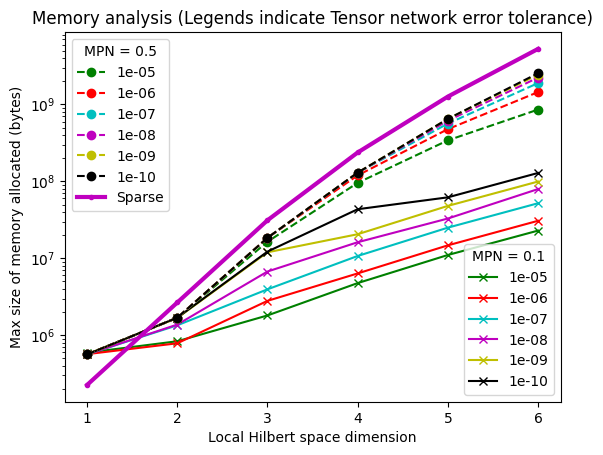

In [19]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
truncations = [1,2,3,4,5,6]

plt.figure()
plt.title("Memory analysis (Legends indicate Tensor network error tolerance)")
# plt.ylim(10**-1,10**2.5)
plt.xlabel("Local Hilbert space dimension")
plt.ylabel("Max size of memory allocated (bytes)")

# TN: 0.1
data_file = open("final_data/memory_data_mpn10.json", 'r')
data = json.load(data_file)

for (key,value), color in zip(list(data.items()), colors):
    if not key == "0.0001":
        plt.plot(truncations, value, label=f"{key}", color = color, marker='x')
        print(value, key)
first_legend = plt.legend(loc = 4, title = "MPN = 0.1")
plt.gca().add_artist(first_legend)
# plt.yscale('log')

# TN: 0.5
data_file = open("final_data/memory_data_mpn50.json", 'r')
data = json.load(data_file)

plots_50 = []
for (key,value), color in zip(list(data.items()), colors):
    if not key == "0.0001":
        plots_50.append(plt.plot(truncations, value, label=f"{key}", color = color, linestyle='dashed', marker='o')[0])
        print(value, key)
# plt.legend()
# plt.yscale('log')

# Sparse:
data_file = open("final_data/sparse_memory_data_mpn50.json", 'r')
data = json.load(data_file)
# print(type(data))

# data = (list(map(float, re.findall(r"([0-9]+.[0-9]+)", data))))
plots_50.append(plt.plot(truncations, data, marker='.', linewidth = 3,  color="m", label = "Sparse")[0])


plt.legend(handles = plots_50, loc = 2, title = "MPN = 0.5")

# for (key,value), color in zip(list(data.items()), colors):
#     plt.plot(truncations, value, label=f"{key}, MPN=0.5", color = color, linestyle='dashed', marker='o')
#     print(value, key)
# plt.legend(loc = 4)
plt.yscale('log')

In [21]:
from swap_sparse_direct import *

mean_photon_num = 0.1
num_modes = 8
efficiency = 0.9
truncations = [1,2,3,4,5,6]
# truncations = [1,2,3]

sparse_data = []
num_iter = 2
for trunc in truncations:

    a = qt.destroy(trunc+1).full()
    a = sp.csr_matrix(a)
    a_dag = a.T
    
    time_taken = 0
    for iter in range(num_iter):
        N = trunc+1
        vacuum = create_vacuum_state(num_modes=num_modes, N=N)
        
        psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, 1e-10)

        start = time.time()
        # Sparse matrix data:
        TMSV_state_dense = extend_state_sparse(TMSV_state)
        post_BSM_State = bell_state_measurement_sparse(TMSV_state_dense, N, efficiency, a_dag)
        coincidence, idler_angles = rotate_and_measure_sparse(post_BSM_State, N, efficiency, a_dag)

        time_taken += time.time() - start
        print("iter:", iter)

    sparse_data.append(time_taken/num_iter)
    print(trunc)


(256, 256) 128 128
iter: 0
(256, 256) 128 128
iter: 1
1
(6561, 6561) 4374 4374
iter: 0
(6561, 6561) 4374 4374
iter: 1
2
(65536, 65536) 49152 49152
iter: 0
(65536, 65536) 49152 49152
iter: 1
3
(390625, 390625) 312500 312500
iter: 0
(390625, 390625) 312500 312500
iter: 1
4
(1679616, 1679616) 1399680 1399680
iter: 0
(1679616, 1679616) 1399680 1399680
iter: 1
5
(5764801, 5764801) 4941258 4941258
iter: 0
(5764801, 5764801) 4941258 4941258
iter: 1
6


[0.18248069286346436, 0.30002641677856445, 2.0140312910079956, 11.91563880443573, 80.37059247493744, 353.5060969591141]
[0.18248069286346436, 0.30002641677856445, 2.0140312910079956, 11.91563880443573, 80.37059247493744, 353.5060969591141]


/tmp/ipykernel_2875030/2173916565.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


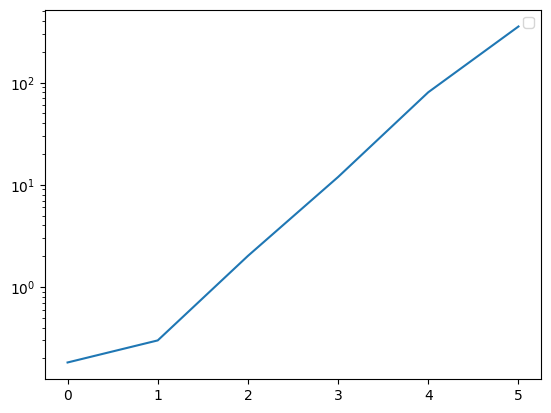

In [22]:
timing_data = sparse_data
print(timing_data)

json.dump(timing_data, open(f"sparse_timing_data_mpn{int(mean_photon_num*100)}.json", "w"))

plt.figure()
# for value in timing_data:
plt.plot(timing_data)
print(timing_data)
plt.legend()
plt.yscale('log')


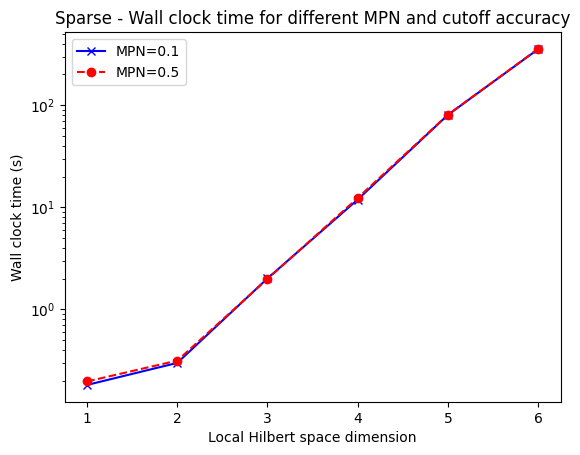

In [40]:
import re

data10_file = open("sparse_timing_data_mpn10.json", 'r')
data10 = data10_file.readline()

data10 = (list(map(float, re.findall(r"([0-9]+.[0-9]+)", data10))))

# print(type(data10))

data50_file = open("sparse_timing_data_mpn50.json", 'r')
data50 = data50_file.readline()

data50 = (list(map(float, re.findall(r"([0-9]+.[0-9]+)", data50))))

truncations = [1,2,3,4,5,6]

plt.figure()
plt.title("Sparse - Wall clock time for different MPN and cutoff accuracy")
# plt.ylim(10**-1,10**2.5)
plt.xlabel("Local Hilbert space dimension")
plt.ylabel("Wall clock time (s)")
plt.plot(truncations, data10, marker='x', color="b", label = "MPN=0.1")
plt.plot(truncations, data50, linestyle='dashed', marker='o', color = "r", label = "MPN=0.5")

plt.legend()
plt.yscale('log')

Common parameters and functions

In [10]:
# params
trunc = 2
N = trunc+1
error_tolerance = 1e-15

mean_photon_num = (0.6)
efficiency = 0.9


num_modes = 8
# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
# psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# trying new ls here:
psi = new_ls(N, mean_photon_num, error_tolerance) 

# Include emission from other lightsource
psi = extend_MPS(psi)

# only for drawing the TN. Not used otherwise
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}

idler_angles = np.linspace(0, np.pi, 15)
signal_angles = np.linspace(0, 2*np.pi, 40)

/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Performing measurements: 

Threshold detection

In [11]:
start = time.time()
# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)

coincidence_Threshold = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False)
print(time.time()-start)

9.232694864273071


PNR detection

In [12]:
start = time.time()
# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = True, compress=True, contract=True)

coincidence_PNR = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = True, compress=True, contract=True, draw = False)
print(time.time()-start)

9.980517864227295


Threshold results

0.936281254393959 [0.00020764929448700595, 0.00025024869066524744, 0.0003767103350218654, 0.0005830832176894581, 0.0008629737421083912, 0.0012078192500544183, 0.0016072449992337438, 0.002049481431208502, 0.0025218156310029063, 0.003011050193185624, 0.0035039442698333065, 0.003987615162761708, 0.00444988402116619, 0.004879555451782011, 0.005266627486212154, 0.00560243470026006, 0.005879732710520839, 0.006092736262749553, 0.0062371253169863404, 0.006310033767601344, 0.006310033767601375, 0.006237125316986279, 0.006092736262749564, 0.005879732710520826, 0.00560243470026006, 0.005266627486212096, 0.004879555451782009, 0.004449884021166184, 0.003987615162761694, 0.0035039442698333568, 0.0030110501931856575, 0.0025218156310029176, 0.002049481431208492, 0.0016072449992337373, 0.0012078192500544135, 0.0008629737421084053, 0.0005830832176894562, 0.00037671033502186565, 0.0002502486906652451, 0.00020764929448700592]
0.9327625366180136 [0.00029250292999474857, 0.0002208709523090859, 0.00023400204

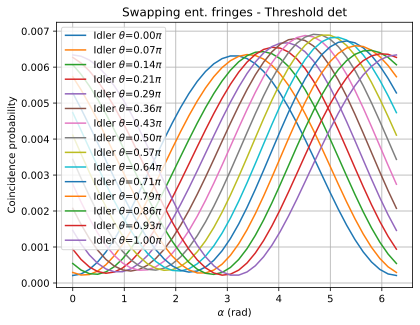

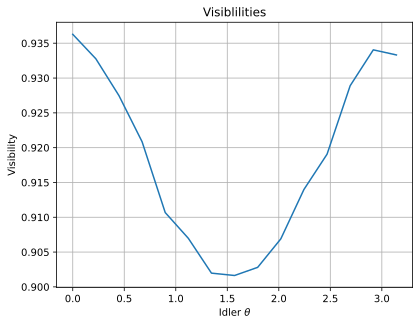

In [13]:
plot_coincidences(coincidence_Threshold, idler_angles, signal_angles, title = "Swapping ent. fringes - Threshold det")

PNR results

0.9773364636907993 [7.854815909596289e-06, 1.2248391581674113e-05, 2.5315327295910047e-05, 4.6717196281026826e-05, 7.589970137219439e-05, 0.00011210703101641647, 0.00015440143439474224, 0.0002016875086759008, 0.0002527405693742405, 0.0003062383690346169, 0.0003607953427469207, 0.0004149984935494721, 0.00046744398830808164, 0.0005167735162568487, 0.0005617094685335223, 0.0006010880275778994, 0.0006338893093953288, 0.0006592637780164646, 0.0006765542480326173, 0.0006853129053526338, 0.0006853129053526311, 0.0006765542480326133, 0.0006592637780164675, 0.000633889309395325, 0.000601088027577892, 0.0005617094685335253, 0.0005167735162568548, 0.00046744398830807714, 0.00041499849354946884, 0.00036079534274691767, 0.00030623836903461495, 0.000252740569374237, 0.00020168750867589834, 0.00015440143439473917, 0.00011210703101641435, 7.589970137219318e-05, 4.671719628102597e-05, 2.5315327295909322e-05, 1.2248391581673656e-05, 7.854815909596331e-06]
0.975468399568482 [1.6588896529570625e-05, 8.527

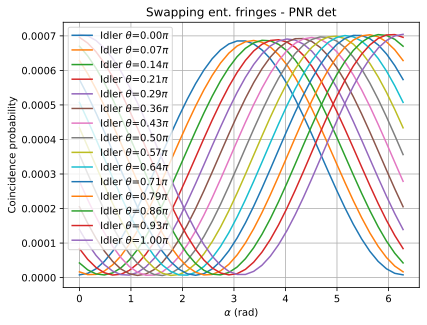

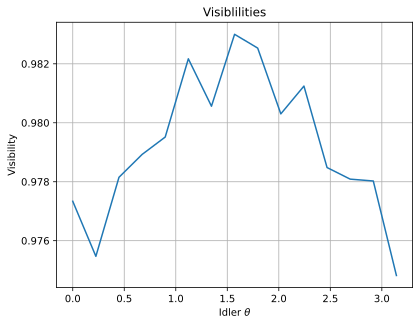

In [14]:
plot_coincidences(coincidence_PNR, idler_angles, signal_angles, title = "Swapping ent. fringes - PNR det")

Performing same simulatiosn for higher truncation

Common parameters and functions

In [10]:
# params
trunc = 3
N = trunc+1
error_tolerance = 1e-15

mean_photon_num = (0.6)
efficiency = 0.9


num_modes = 8
# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
# psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# trying new ls here:
psi = new_ls(N, mean_photon_num, error_tolerance) 

# Include emission from other lightsource
psi = extend_MPS(psi)

# only for drawing the TN. Not used otherwise
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}

idler_angles = np.linspace(0, np.pi, 15)
signal_angles = np.linspace(0, 2*np.pi, 40)

/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Performing measurements: 

Threshold detection

In [11]:
start = time.time()
# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)

coincidence_Threshold = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False)
print(time.time()-start)

83.91316938400269


PNR detection

In [12]:
start = time.time()
# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = True, compress=True, contract=True)

coincidence_PNR = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = True, compress=True, contract=True, draw = False)
print(time.time()-start)

82.82326197624207


Threshold results

0.888112605903909 [0.0003574350742894173, 0.00040997300144098866, 0.0005649233837776098, 0.0008145238179103809, 0.001146539240059524, 0.001545239692862794, 0.001992609217864748, 0.0024696604098074747, 0.0029577198015210784, 0.0034395617998907815, 0.0039002948707473214, 0.004327939031365725, 0.004713672885445123, 0.005051765913065543, 0.005339242948918591, 0.005575349770768765, 0.005760900336722951, 0.005897588013989019, 0.0059873369397103245, 0.006031757867007337, 0.006031757867007347, 0.005987336939710258, 0.005897588013988921, 0.005760900336722939, 0.005575349770768725, 0.005339242948918549, 0.005051765913065604, 0.004713672885445109, 0.004327939031365707, 0.0039002948707473326, 0.0034395617998908036, 0.0029577198015210376, 0.0024696604098074807, 0.0019926092178647304, 0.0015452396928628093, 0.0011465392400595098, 0.0008145238179103762, 0.000564923383777607, 0.0004099724276247574, 0.00035743507428942137]
0.8850104105579719 [0.0004598191895765168, 0.0003777137940111233, 0.000399695955

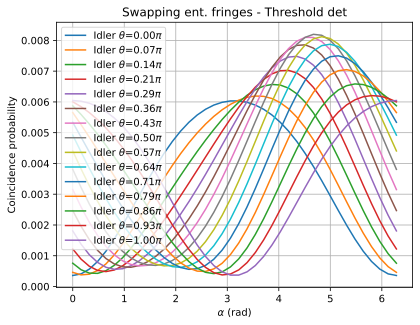

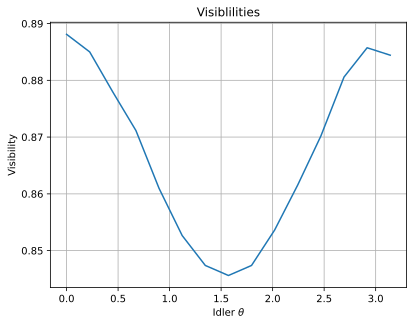

In [13]:
plot_coincidences(coincidence_Threshold, idler_angles, signal_angles, title = "Swapping ent. fringes - Threshold det")

PNR results

0.9746562013179682 [9.790273085513856e-06, 1.4673896794959355e-05, 2.9198196428110215e-05, 5.298706626478848e-05, 8.542436487664345e-05, 0.0001256699832681548, 0.0001726815810630311, 0.00022524158257244663, 0.00028198871136580014, 0.0003414532466152413, 0.0004020950880930912, 0.0004623436439587691, 0.0005206385082624563, 0.0005754698746395792, 0.0006254176395025647, 0.0006691881819778055, 0.0007056478680068009, 0.0007338524108728033, 0.0007530713277307322, 0.0007628068587292015, 0.000762806858729204, 0.0007530713277307267, 0.0007338524108727962, 0.0007056478680068003, 0.0006691881819778003, 0.0006254176395025586, 0.000575469874639576, 0.0005206385082624597, 0.00046234364395876586, 0.00040209508809308897, 0.00034145324661524046, 0.00028198871136580046, 0.00022524158257244628, 0.00017268158106303105, 0.00012566998326815602, 8.54243648766424e-05, 5.298706626478817e-05, 2.9198196428110404e-05, 1.4673874599657618e-05, 9.79027308551374e-06]
0.9730580350428641 [1.9376703881372522e-05, 1.04367

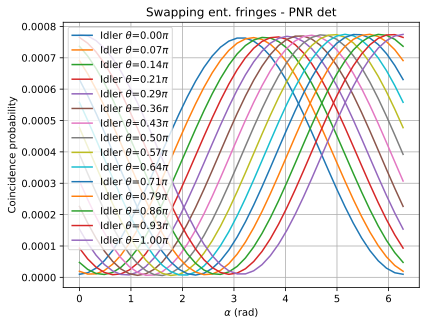

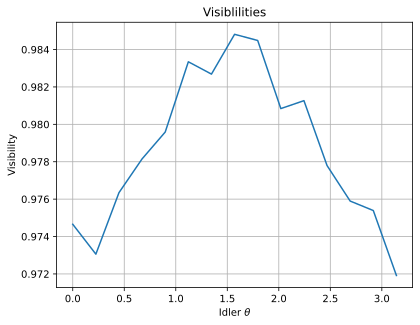

In [ ]:
plot_coincidences(coincidence_PNR, idler_angles, signal_angles, title = "Swapping ent. fringes - PNR det")

## Performing the same simulations with lower detector efficiency

In [ ]:
# params
trunc = 3
N = trunc+1
# mean_photon_num = 0.02
# num_modes = 8
# efficiency = 0.9
error_tolerance = 1e-15

mean_photon_num = (0.6)
num_modes = 8
efficiency = 0.5 # 0.9
initial_error_tolerance = 1e-15

# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
# psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# trying new ls here:
psi = new_ls(N, mean_photon_num, error_tolerance) 

# Include emission from other lightsource
start = time.time()
psi = extend_MPS(psi)

error_tolerance = 1e-15

# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = True, compress=True, contract=True)

# psi.draw()

# Rotate polarizers and perform measurements
# idler_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
idler_angles = np.linspace(0, np.pi, 15) # 15)
signal_angles = np.linspace(0, 2*np.pi, 40)
# signal_angles = [0]
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}
coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = True, compress=True, contract=True, draw = False)
print(time.time()-start)

/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


91.33076286315918


0.634391100202672 [0.00018075869836316801, 0.0001848271983711996, 0.00019692624230414338, 0.00021674328257176412, 0.00024376479545476759, 0.0002772909379632332, 0.00031645340061666415, 0.00036023789620343266, 0.000407510429286774, 0.00045704666609095167, 0.0005075636441029232, 0.0005577530001275287, 0.0006063148562069812, 0.0006519914857772099, 0.0006935998881251396, 0.0007300624274858779, 0.0007604347432428667, 0.0007839302083718363, 0.0007999403026675443, 0.0008080503730974549, 0.0008080503730974555, 0.0007999403026675405, 0.0007839302083718285, 0.0007604347432428684, 0.0007300624274858844, 0.000693599888125136, 0.0006519914857772054, 0.0006063148562069788, 0.0005577530001275241, 0.0005075636441029248, 0.00045704666609095004, 0.00040751042928677587, 0.0003602378962034291, 0.00031645340061666664, 0.0002772909379632355, 0.00024376479545477116, 0.00021674328257176293, 0.00019692624230414405, 0.00018482692558542734, 0.00018075869836316915]
0.633278449170395 [0.00018871129123387045, 0.000

Text(0.5, 0, 'Idler $\\theta$')

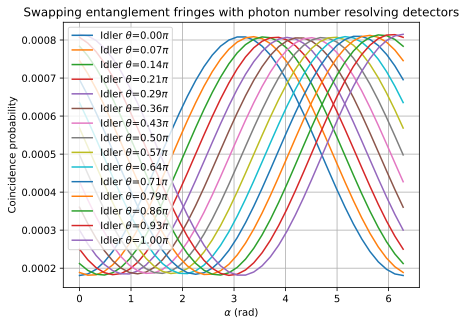

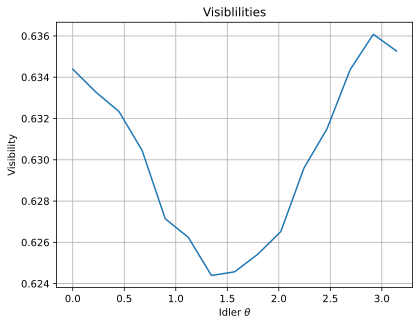

In [13]:
visibilities = []
for i in range(len(coincidence)):
    visibility = (max(coincidence[i]) - min(coincidence[i])) / (max(coincidence[i]) + min(coincidence[i]))
    visibilities.append(visibility)
    print(visibility, coincidence[i])

plt.figure()
plt.grid(True)
for i in range(len(idler_angles)):
    # print(fringe_real[i])
    plt.plot(signal_angles, coincidence[i], label=r'Idler $\theta$={:.2f}$\pi$'.format(idler_angles[i]/np.pi))
plt.title("Swapping entanglement fringes with photon number resolving detectors")
plt.ylabel("Coincidence probability")
plt.xlabel(r"$\alpha$ (rad)")    
plt.legend()

plt.figure()
plt.grid(True)
# for i in range(len(alpha_list)-1):
#     print(fringe_real[i])
plt.plot(idler_angles, visibilities)
plt.title("Visiblilities")
plt.ylabel("Visibility")
plt.xlabel(r"Idler $\theta$")    
# plt.legend()

This simulation is using the threshold detectors (original definition of POVM operator). 

In [14]:
# params
trunc = 3
N = trunc+1
# mean_photon_num = 0.02
# num_modes = 8
# efficiency = 0.9
error_tolerance = 1e-20

mean_photon_num = 0.6
num_modes = 8
efficiency = 0.5

# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
# psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# trying new ls here:
psi = new_ls(N, mean_photon_num, error_tolerance) 

# Include emission from other lightsource
start = time.time()
psi = extend_MPS(psi)

read_quantum_state(psi, N, num_states = 4)


# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)

read_quantum_state(psi, N, num_states = 4)

# psi.draw()

# Rotate polarizers and perform measurements
# idler_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
idler_angles = np.linspace(0, np.pi, 15) # 15)
signal_angles = np.linspace(0, 2*np.pi, 40)
# signal_angles = [0]
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}
coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False)
print(time.time()-start)

Corresponding Basis terms:
0H0V_D 0H0V_C 0H0V_B 0H0V_A - 0 - [0.33112129+0.j]
0H0V_D 0H0V_C 0H1V_B 0H1V_A - 10 - [0.+0.18736198j]
0H0V_D 0H0V_C 0H2V_B 0H2V_A - 20 - [-0.26460474+0.j]
0H0V_D 0H0V_C 1H0V_B 1H0V_A - 30 - [0.+0.18736198j]
0H0V_D 0H0V_C 1H1V_B 1H1V_A - 40 - [-0.10601708+0.j]
0H0V_D 0H0V_C 2H0V_B 2H0V_A - 60 - [-0.26460474+0.j]
0H1V_D 0H1V_C 0H0V_B 0H0V_A - 810 - [0.+0.18736198j]
0H1V_D 0H1V_C 0H1V_B 0H1V_A - 820 - [-0.10601708+0.j]
0H1V_D 0H1V_C 0H2V_B 0H2V_A - 830 - [-0.-0.14972419j]
0H1V_D 0H1V_C 1H0V_B 1H0V_A - 840 - [-0.10601708+0.j]
0H1V_D 0H1V_C 1H1V_B 1H1V_A - 850 - [-0.-0.0599888j]
0H1V_D 0H1V_C 2H0V_B 2H0V_A - 870 - [-0.-0.14972419j]
0H2V_D 0H2V_C 0H0V_B 0H0V_A - 1620 - [-0.26460474+0.j]
0H2V_D 0H2V_C 0H1V_B 0H1V_A - 1630 - [-0.-0.14972419j]
0H2V_D 0H2V_C 0H2V_B 0H2V_A - 1640 - [0.21145022-0.j]
0H2V_D 0H2V_C 1H0V_B 1H0V_A - 1650 - [-0.-0.14972419j]
0H2V_D 0H2V_C 1H1V_B 1H1V_A - 1660 - [0.08472008-0.j]
0H2V_D 0H2V_C 2H0V_B 2H0V_A - 1680 - [0.21145022-0.j]
1H0V_D 1H0

0.8235598463979527 [6.8844862131526995e-06, 7.2758396265781815e-06, 8.441727849129548e-06, 1.0357644347367135e-05, 1.2982797189083608e-05, 1.6260256758682255e-05, 2.0117291782646612e-05, 2.4466002136694812e-05, 2.9204360796217694e-05, 3.421776501956543e-05, 3.9381168909902105e-05, 4.456182812816508e-05, 4.96226365072387e-05, 5.442597858703712e-05, 5.883796725342489e-05, 6.273288740994649e-05, 6.599763012997153e-05, 6.853588117859177e-05, 7.027182583234065e-05, 7.115314946789921e-05, 7.115314946789889e-05, 7.027182583234086e-05, 6.853588117859149e-05, 6.599763012997143e-05, 6.273288740994615e-05, 5.8837967253424456e-05, 5.442597858703647e-05, 4.962263650723853e-05, 4.456182812816498e-05, 3.938116890990225e-05, 3.421776501956539e-05, 2.9204360796217637e-05, 2.4466002136694812e-05, 2.0117291782646642e-05, 1.6260256758682238e-05, 1.298279718908368e-05, 1.0357644347367145e-05, 8.441727849129503e-06, 7.275839626578107e-06, 6.884486213152729e-06]
0.8028146366008012 [7.700706214380577e-06, 7.8

Text(0.5, 0, 'Idler $\\theta$')

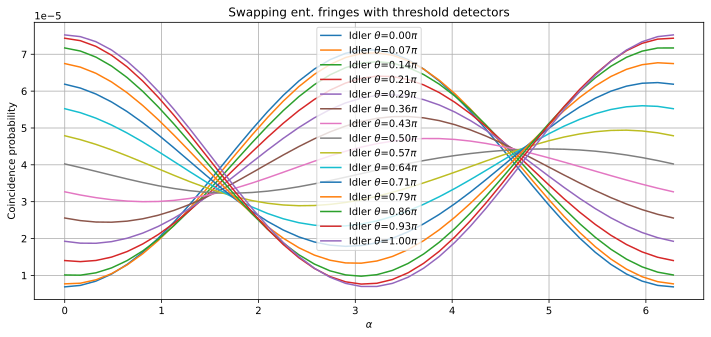

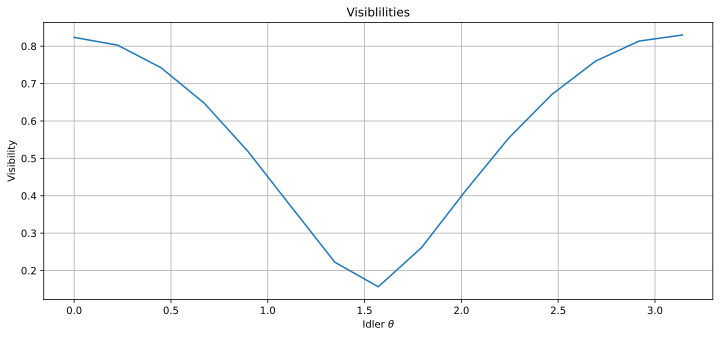

Bad pipe message: %s [b'\xf6v', b'\xe9\x11o\xedol\xa2\xa9\x88\xe6\x15\xd2\xfaq\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0']
Bad pipe message: %s [b'\n\xc0\x0b\xc0\x0c\xc0\r\xc0']
Bad pipe message: %s [b'\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15']
Bad pip

In [15]:
visibilities = []
for i in range(len(coincidence)):
    visibility = (max(coincidence[i]) - min(coincidence[i])) / (max(coincidence[i]) + min(coincidence[i]))
    visibilities.append(visibility)
    print(visibility, coincidence[i])

plt.figure(figsize = (12,5))
plt.grid(True)
for i in range(len(idler_angles)):
    # print(fringe_real[i])
    plt.plot(signal_angles, coincidence[i], label=r'Idler $\theta$={:.2f}$\pi$'.format(idler_angles[i]/np.pi))
plt.title("Swapping ent. fringes with threshold detectors")
plt.ylabel("Coincidence probability")
plt.xlabel(r"$\alpha$")    
plt.legend()

plt.figure(figsize = (12,5))
plt.grid(True)
# for i in range(len(alpha_list)-1):
#     print(fringe_real[i])
plt.plot(idler_angles, visibilities)
plt.title("Visiblilities")
plt.ylabel("Visibility")
plt.xlabel(r"Idler $\theta$")    
# plt.legend()

In [22]:
# params
trunc = 3
N = trunc+1
# mean_photon_num = 0.02
# num_modes = 8
# efficiency = 0.9
error_tolerance = 1e-15

mean_photon_num = np.sqrt(0.06)
num_modes = 8
efficiency = 0.9
initial_error_tolerance = 1e-15

# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# Include emission from other lightsource
start = time.time()
psi = extend_MPS(psi)

error_tolerance = 1e-15

# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)

# psi.draw()

# Rotate polarizers and perform measurements
# idler_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
idler_angles = np.linspace(0, np.pi/2, 10)
signal_angles = np.linspace(0, np.pi, 20)
# signal_angles = [0]
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}
coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, compress=True, contract=True, draw = False)
print(time.time()-start)

# plt.grid()
# for i in range(len(idler_angles)):
#     plt.plot((coincidence[i]), label = f"{i}")
# plt.legend()





SystemError: CPUDispatcher(<function qr_stabilized_numba at 0x7fc87f9c4280>) returned a result with an exception set

0.7652262665052498 [4.686633243017588e-05, 5.448428491821786e-05, 7.673565784999554e-05, 0.00011178620446153169, 0.0001565295977651937, 0.00020663513518744838, 0.0002567975603158837, 0.00030125525089446444, 0.0003345481594874876, 0.00035238048051215774, 0.0003523804193376696, 0.00033454710173179614, 0.00030125190301760155, 0.00025679253888325615, 0.00020663130122960745, 0.00015652966527179558, 0.00011179012322290021, 7.6740663159089e-05, 5.4487558702594295e-05, 4.686733662012374e-05]
0.7788363827956937 [5.534784548482949e-05, 4.386667589192364e-05, 4.80819312821034e-05, 6.811468853498462e-05, 0.00010248742078421705, 0.00014799372851830261, 0.0001998253887124572, 0.0002520373362911063, 0.00029832737290870986, 0.0003329916700661508, 0.0003518369858130958, 0.00035282312730839684, 0.0003362832036581137, 0.0003046979450709991, 0.00026213205040144554, 0.0002135222097506962, 0.0001640093802368149, 0.00011844018081062942, 8.106197346982771e-05, 5.535021887200222e-05]
0.8140451469047519 [8.0043

/tmp/ipykernel_791070/3421890716.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


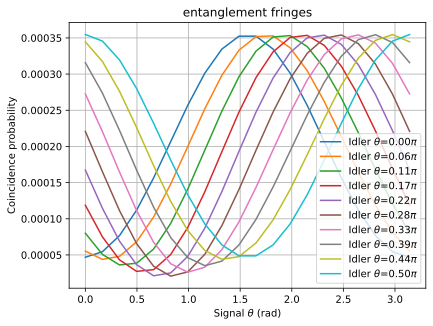

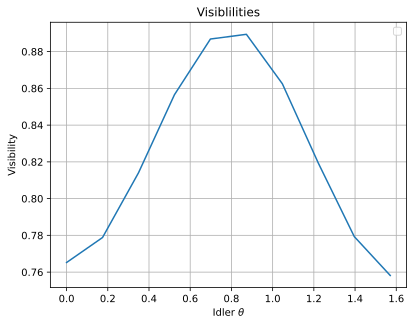

In [15]:
visibilities = []
for i in range(len(coincidence)):
    visibility = (max(coincidence[i]) - min(coincidence[i])) / (max(coincidence[i]) + min(coincidence[i]))
    visibilities.append(visibility)
    print(visibility, coincidence[i])

plt.figure()
plt.grid(True)
for i in range(len(idler_angles)):
    # print(fringe_real[i])
    plt.plot(signal_angles, coincidence[i], label=r'Idler $\theta$={:.2f}$\pi$'.format(idler_angles[i]/np.pi))
plt.title("entanglement fringes")
plt.ylabel("Coincidence probability")
plt.xlabel(r"Signal $\theta$ (rad)")    
plt.legend()

plt.figure()
plt.grid(True)
# for i in range(len(alpha_list)-1):
#     print(fringe_real[i])
plt.plot(idler_angles, visibilities)
plt.title("Visiblilities")
plt.ylabel("Visibility")
plt.xlabel(r"Idler $\theta$")    
plt.legend()

237.84472703933716


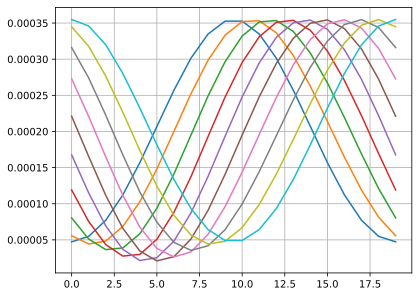

In [9]:
# params
trunc = 4
N = trunc+1
# mean_photon_num = 0.02
# num_modes = 8
# efficiency = 0.9
error_tolerance = 1e-15

mean_photon_num = np.sqrt(0.06)
num_modes = 8
efficiency = 0.9
initial_error_tolerance = 1e-15

# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# Include emission from other lightsource
start = time.time()
psi = extend_MPS(psi)

error_tolerance = 1e-15

# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)

# psi.draw()

# Rotate polarizers and perform measurements
# idler_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
idler_angles = np.linspace(0, np.pi/2, 10)
signal_angles = np.linspace(0, np.pi, 20)
# signal_angles = [0]
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}
coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, compress=True, contract=True, draw = False)
print(time.time()-start)

plt.grid()
for i in range(len(idler_angles)):
    plt.plot((coincidence[i]), label = f"{i}")
# plt.legend()

### Statevector version

In [9]:
from numpy import kron
import scipy.sparse as sp

a = qt.destroy(N).full()
a = sp.csr_matrix(a)
a_dag = a.T

# Support functions:
def create_op(left_indices, op, right_indices):
    if left_indices == 0:
        return sp.kron(op, sp.eye(N**right_indices))
    elif right_indices == 0:
        return sp.kron(sp.eye(N**left_indices), op)
    else:    
        out_op = sp.kron(sp.eye(N**left_indices), op)
        return sp.kron(out_op, sp.eye(N**right_indices))
def _find_mat_exp(mat):
    ans = sp.eye(mat.shape[0])
    intermediate = 1
    for i in range(1, 50+1):
        intermediate *= mat/i
        intermediate.eliminate_zeros()
        ans += intermediate
    return ans 
def read_quantum_state_sparse(sparse_state, N):
    temp_sparse_state = sp.csr_matrix(sparse_state)
    temp_sparse_state.data = np.round(temp_sparse_state.data, 10)
    temp_sparse_state.eliminate_zeros()
    labels = generate_labels(4,N)
    state = temp_sparse_state.nonzero()[0]
    print(f"{len(state)} non-zero elements Corresponding Basis terms:")
    for k in state: print(labels[k],"-",k,"-",temp_sparse_state[k].data)

def extend_state_sparse(state):
    return sp.kron(state, state)
# TMSV_state_dense = extend_state_sparse(TMSV_state)

def bell_state_measurement_sparse(TMSV_state_dense, N, efficiency):
    # BSM BS implementation
    BSM_H_0_Mode_op = create_op(2, a_dag, 5)
    print(BSM_H_0_Mode_op.shape, len(BSM_H_0_Mode_op.nonzero()[0]), len(BSM_H_0_Mode_op.nonzero()[1]))
    BSM_V_0_Mode_op = create_op(3, a_dag, 4)
    BSM_H_1_Mode_op = create_op(6, a_dag, 1)
    BSM_V_1_Mode_op = create_op(7, a_dag, 0)
    hamiltonian_BS_H = -np.pi/4 * ( BSM_H_0_Mode_op.T@BSM_H_1_Mode_op - BSM_H_0_Mode_op@BSM_H_1_Mode_op.T )
    unitary_BS_H = _find_mat_exp(hamiltonian_BS_H)

    hamiltonian_BS_V = -np.pi/4 * ( BSM_V_0_Mode_op.T@BSM_V_1_Mode_op - BSM_V_0_Mode_op@BSM_V_1_Mode_op.T )
    unitary_BS_V = _find_mat_exp(hamiltonian_BS_V)


    # BSM povm implementation
    povm_op_1 = sp.csr_matrix(create_POVM_OP_Dense(efficiency, 1, N))
    povm_op_0 = sp.csr_matrix(create_POVM_OP_Dense(efficiency, 0, N))

    BSM_povm = create_op(2, povm_op_1, 0)
    BSM_povm = create_op(0, sp.kron(BSM_povm, povm_op_0), 2)
    BSM_povm = sp.kron(BSM_povm, sp.kron(povm_op_0, povm_op_1))

    # print(unitary_BS_V.shape, unitary_BS_H.shape, TMSV_state_dense.shape)
    
    post_BS_State = unitary_BS_V @ unitary_BS_H @ TMSV_state_dense
    post_BSM_State = BSM_povm @ post_BS_State

    return post_BSM_State
# post_BSM_State = bell_state_measurement_sparse(TMSV_state_dense, N, efficiency)

def rotate_and_measure_sparse(post_BSM_State, N, efficiency):
    # Polarization rotators mode operators
    rotator_H_0_Mode_op = create_op(0, a_dag, 7)
    rotator_V_0_Mode_op = create_op(1, a_dag, 6)
    rotator_H_1_Mode_op = create_op(4, a_dag, 3)
    rotator_V_1_Mode_op = create_op(5, a_dag, 2)

    povm_op_1 = sp.csr_matrix(create_POVM_OP_Dense(efficiency, 1, N))

    # polarization analysis detector POVMs
    pol_analyzer_povm = create_op(0, povm_op_1, 3)
    pol_analyzer_povm = create_op(0, sp.kron(pol_analyzer_povm, povm_op_1), 3)

    # Applying rotations and measuring

    signal_angles = np.linspace(0, np.pi, 10)
    # idler_angles = np.linspace(0, np.pi, 20)
    idler_angles = [0]
    coincidence = []

    for i, idler_angle in enumerate(idler_angles):
        coincidence_probs = []

        hamiltonian_rotator_1 = -idler_angle * ( rotator_H_1_Mode_op.T@rotator_V_1_Mode_op - rotator_H_1_Mode_op@rotator_V_1_Mode_op.T )
        unitary_rotator_1 = _find_mat_exp(hamiltonian_rotator_1)
        post_idler_detection_state = unitary_rotator_1 @ post_BSM_State
        # post_idler_detection_state = post_BSM_State
        
        for j, angle in enumerate(signal_angles):
            # print("idler:", i, "signal:", j)
        
            hamiltonian_rotator_0 = -angle * ( rotator_H_0_Mode_op.T@rotator_V_0_Mode_op - rotator_H_0_Mode_op@rotator_V_0_Mode_op.T )
            unitary_rotator_0 = _find_mat_exp(hamiltonian_rotator_0)
            post_rotations_state = unitary_rotator_0 @ post_idler_detection_state

            measured_state = pol_analyzer_povm @ post_rotations_state

            coincidence_probs.append(sp.linalg.norm(measured_state)**2)
        coincidence.append(coincidence_probs)
    return coincidence, idler_angles
# coincidence, idler_angles = rotate_and_measure_sparse(post_BSM_State, N, efficiency)

done with extension
(65536, 65536) 49152 49152
done with bell_state_measurement_sparse
done with rotate_and_measure_sparse


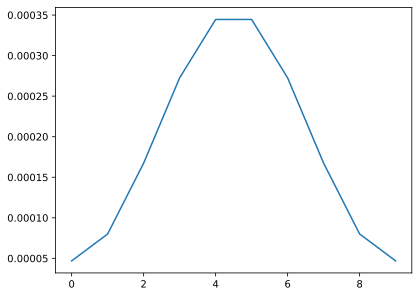

In [10]:
# read_quantum_state_sparse(TMSV_state, N)

TMSV_state_dense = extend_state_sparse(TMSV_state)
print("done with extension")
# read_quantum_state_sparse(TMSV_state_dense, N)
post_BSM_State = bell_state_measurement_sparse(TMSV_state_dense, N, efficiency)
print("done with bell_state_measurement_sparse")

# state_indices, _ = post_BSM_State.nonzero()
# num_photons = 2
# for n in state_indices:
#     for i in range(num_photons):
#         H = (n // (N**(2*i+1))) % N
#         V = (n // (N**(2*i+0))) % N
#         # print("n:", n, "H:", H, "V:", V, "i", i, "Val:", entangled_state[n,0])
#         if H+V > trunc:
#             # print("deleted:", n)
#             post_BSM_State[n,0] = 0  

# read_quantum_state_sparse(post_BSM_State, N) 

# read_quantum_state_sparse(post_BSM_State, N)
coincidence, idler_angles = rotate_and_measure_sparse(post_BSM_State, N, efficiency)
print("done with rotate_and_measure_sparse")

for i in range(len(idler_angles)):
    plt.plot((coincidence[i]), label = f"{i}")
# plt.legend()

Performance comparisons

In [11]:
# params
mean_photon_num = 0.2
num_modes = 8
efficiency = 0.9
initial_error_tolerance = 1e-15
truncations = [1,2,3,4,5,6]
error_tolerances = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
TN_data = []
sparse_data = []

num_iter = 5

for error_tolerance in error_tolerances:
    TN_data_error_tol = []
    for trunc in truncations:
        N = trunc+1
        vacuum = create_vacuum_state(num_modes=num_modes, N=N)
        
        time_taken = 0
        for iter in range(num_iter):
            psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, initial_error_tolerance)
            # TN data:
            start = time.time()
            psi = extend_MPS(psi)
            psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance)
            idler_angles = [0]
            coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles)
            time_taken += time.time() - start
        
        TN_data_error_tol.append(time_taken/num_iter)
        
        print("truncation:", trunc)
    print("error:", error_tolerance)
    TN_data.append(TN_data_error_tol)

truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-05
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-06
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-07
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-08
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-09
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-10


In [12]:
corrected_TN_data = []
for i in TN_data[:6]:
    corrected_TN_data.append([2*j for j in i])
corrected_TN_data

[[0.37795286178588866,
  0.49544363021850585,
  1.160251522064209,
  1.8715259552001953,
  3.6817642211914063,
  6.2446390151977536],
 [0.37921533584594724,
  0.5582192420959473,
  2.207474422454834,
  4.248854732513427,
  5.60923137664795,
  8.473978233337402],
 [0.3784365653991699,
  0.5515198707580566,
  2.335206699371338,
  5.527664089202881,
  8.341994571685792,
  12.478046989440918],
 [0.37646961212158203,
  0.7961133003234864,
  6.180577373504638,
  9.55179042816162,
  14.224153995513916,
  19.299321365356445],
 [0.39735660552978513,
  0.9513609886169434,
  5.009572887420655,
  10.528872203826904,
  15.55453701019287,
  22.058192825317384],
 [0.38264780044555663,
  0.9167355537414551,
  8.105130481719971,
  14.237593746185302,
  23.17667531967163,
  33.90475454330444]]

[0.37795286178588866, 0.49544363021850585, 1.160251522064209, 1.8715259552001953, 3.6817642211914063, 6.2446390151977536] 1e-05
[0.37921533584594724, 0.5582192420959473, 2.207474422454834, 4.248854732513427, 5.60923137664795, 8.473978233337402] 1e-06
[0.3784365653991699, 0.5515198707580566, 2.335206699371338, 5.527664089202881, 8.341994571685792, 12.478046989440918] 1e-07
[0.37646961212158203, 0.7961133003234864, 6.180577373504638, 9.55179042816162, 14.224153995513916, 19.299321365356445] 1e-08
[0.39735660552978513, 0.9513609886169434, 5.009572887420655, 10.528872203826904, 15.55453701019287, 22.058192825317384] 1e-09
[0.38264780044555663, 0.9167355537414551, 8.105130481719971, 14.237593746185302, 23.17667531967163, 33.90475454330444] 1e-10


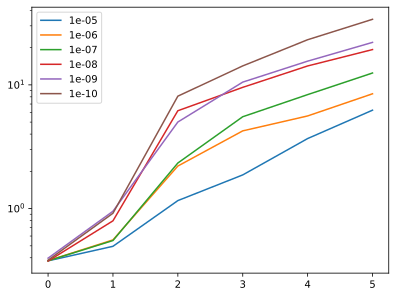

In [13]:

for i in range(len(corrected_TN_data)):
    plt.plot(corrected_TN_data[i], label=f"{error_tolerances[i]}")
    print(corrected_TN_data[i], error_tolerances[i])
plt.legend()
plt.yscale('log')


In [ ]:
sparse_data = []
num_iter = 2
for trunc in truncations:

    a = qt.destroy(trunc+1).full()
    a = sp.csr_matrix(a)
    a_dag = a.T
    
    time_taken = 0
    for iter in range(num_iter):
        N = trunc+1
        vacuum = create_vacuum_state(num_modes=num_modes, N=N)
        
        psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, initial_error_tolerance)

        start = time.time()
        # Sparse matrix data:
        TMSV_state_dense = extend_state_sparse(TMSV_state)
        post_BSM_State = bell_state_measurement_sparse(TMSV_state_dense, N, efficiency)
        coincidence, idler_angles = rotate_and_measure_sparse(post_BSM_State, N, efficiency)

        time_taken += time.time() - start
        print("iter:", iter)

    sparse_data.append(time_taken/num_iter)
    print(trunc)



(256, 256) 128 128
iter: 0
(256, 256) 128 128
iter: 1
1
(6561, 6561) 4374 4374
iter: 0
(6561, 6561) 4374 4374
iter: 1
2
(65536, 65536) 49152 49152
iter: 0
(65536, 65536) 49152 49152
iter: 1
3
(390625, 390625) 312500 312500
iter: 0
(390625, 390625) 312500 312500
iter: 1
4
(1679616, 1679616) 1399680 1399680


{1e-05: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-06: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-07: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-08: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-09: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-10: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736]}


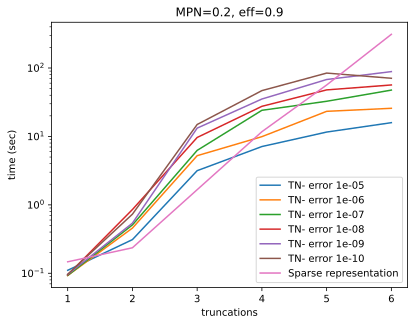

In [ ]:
import json
for i in range(len(corrected_TN_data)):
    plt.plot(truncations, corrected_TN_data[i], label=f"TN- error {error_tolerances[i]}")
plt.plot(truncations, sparse_data, label="Sparse representation")
plt.legend()
plt.yscale('log')
plt.ylabel("time (sec)")
plt.xlabel("truncations")
plt.title("MPN=0.2, eff=0.9")

time_dict_TN = {err:times for err in error_tolerances for times in corrected_TN_data}
time_sparse = sparse_data
truncations = truncations
print(time_dict_TN)

json_file = open("projects/swapping/timing_analysis/TN_data_mpn02.json", "a+")
json.dump(time_dict_TN, json_file)
sparse_data_file = open("projects/swapping/timing_analysis/sparse_data_mpn02.txt", "a+")
np.savetxt(sparse_data_file, time_sparse)
# truncations_file = open("projects/swapping/timing_analysis/truncations.txt", "a+")
# np.savetxt(truncations_file, truncations)

In [ ]:
print()

### Create density matrix

In [ ]:
psi_H = psi.H
# psi_H.retag_({'I{}': 'Out{}'})
psi_H.site_ind_id = 'b{}'
psi_H.combine(psi)
rho = (psi_H | psi)

for i in range(rho.L):
    rho ^= f"I{i}"
    
rho = rho.fuse_multibonds()   
rho = mpo(rho.arrays)
rho.compress(cutoff = 1e-5)

rho